Dropped AGN
Dropped RTN
Dropped CELG
Dropped MON
Correctly predicted sectors for 21 of 37 stocks
Correctly predicted sectors for 30 of 37 stocks


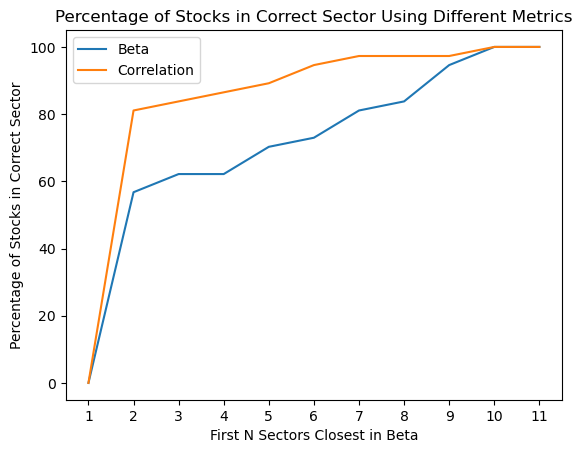

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import threading

attributes = ['sector', 'exchange', 'currency']
start_date = '2023-10-01'
end_date = '2024-10-01'

# Each industry is mapped to (% share of S&P500, % share of TSX60, S&P industry ticker, TSX60 capped industry ticker)
# To obtain values for % share, run market_by_sector('SP500') and market_by_sector('TSX60'), respectively
sectors = {
    'Basic Materials': (0.0171, 0.0849, '^SP500-15', '^GSPTTMT'),
    'Industrials': (0.0719, 0.1311, '^SP500-20', '^GSPTTIN'),
    'Consumer Cyclical': (0.1075, 0.0531, '^SP500-25', '^GSPTTCD'),
    'Consumer Defensive': (0.0576, 0.0509, '^SP500-30', '^GSPTTCS'),
    'Healthcare': (0.1014, 0.0000, '^SP500-35', '^GSPTTHC'),
    'Financial Services': (0.1303, 0.3387, '^SP500-40', '^SPTTFS'),
    'Technology': (0.3045, 0.0963, '^SP500-45', '^SPTTTK'),
    'Communication Services': (0.1340, 0.0304, '^SP500-50', '^GSPTTTS'),
    'Utilities': (0.0235, 0.0318, '^SP500-55', '^GSPTTUT'),
    'Real Estate': (0.0207, 0.0062, '^SP500-60', '^GSPTTRE'),
    'Energy': (0.0315, 0.1766, '^SP500-1010', '^SPTTEN')
}

# adds ticker info to data df
def get_data(ticker, data, history):
    yf_data = yf.Ticker(ticker).info
    # check if stock is CAD or USD
    if('currency' not in yf_data or yf_data['currency'] not in ['USD', 'CAD']):
        data.drop(ticker, inplace=True)
        print('Dropped', ticker)
        return
    for att in attributes:
        if(att not in yf_data):
            print(ticker, 'missing', att)
            continue
        data.loc[ticker, att] = yf_data[att]
    hist = yf.Ticker(ticker).history(start=start_date, end=end_date)
    history[ticker] = hist['Close']
    volume = hist['Volume'].resample('MS').sum()
    # Take all months with >= 18 trading days for volume calculation
    volume.drop([month for month in volume.index if hist.resample('MS').size().loc[month] < 18], inplace=True)
    # check if stock has at least 100,000 average monthly volume
    if(volume.mean() < 1e5):
        data.drop(ticker, inplace=True)

# returns df containing all ticker info
def get_tickers():
    tickers = pd.read_csv('Tickers.csv', header=None)
    data = pd.DataFrame(index=[ticker for ticker in tickers[0]])
    history = {}
    threads = [threading.Thread(target=get_data, args=(ticker,data,history)) for ticker in tickers[0]]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    return (data, history)

# adds market cap of ticker to data table
def ticker_by_sector(ticker, data):
    yf_data = yf.Ticker(ticker).info
    data[yf_data['sector']] += yf_data['marketCap']

# prints percentage of index in each sector
def market_by_sector(index):
    tickers = pd.read_csv(index+'.csv', header=None)
    data = {sector: 0 for sector in sectors}
    threads = [threading.Thread(target=ticker_by_sector, args=(ticker,data)) for ticker in tickers[0]]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    sum = 0
    for sector in data:
        sum += data[sector]
    for sector in data:
        print(sector, round(data[sector]/sum*100, 2))

# returns function of stocks to sectors as given by f
def calc(data, history, f):
    sector_beta = {stock:{} for stock in data.index}
    for sector in sectors:
        history[sectors[sector][2]] = yf.Ticker(sectors[sector][2]).history(start=start_date, end=end_date)['Close']
        for stock in data.index:
            df = pd.DataFrame({stock: history[stock].pct_change(), sector: history[sectors[sector][2]].pct_change()}).dropna()
            # calculate beta
            beta = f(df, stock, sector)
            sector_beta[stock][sector] = abs(beta-1)
    count = 0
    for stock in data.index:
        a = sorted(sector_beta[stock].items(), key=lambda x: x[1])
        if(data['sector'].loc[stock] == a[0][0]):
            count += 1
    print('Correctly predicted sectors for', count, 'of', len(data.index), 'stocks')
    return sector_beta

def beta(df, stock, sector):
    return df[stock].cov(df[sector])/df[sector].var()

def corr(df, stock, sector):
    return df[stock].corr(df[sector])

data, history = get_tickers()
sector_beta = calc(data, history, beta)
sector_corr = calc(data, history, corr)
graph = [[],[],[]]
for i in range(len(sectors)):
    count = 0
    count2 = 0
    for stock in data.index:
        a = sorted(sector_beta[stock].items(), key=lambda x: x[1])
        b = sorted(sector_corr[stock].items(), key=lambda x: x[1])
        if(data['sector'].loc[stock] in [a[j][0] for j in range(i)]):
            count += 1
        if(data['sector'].loc[stock] in [b[j][0] for j in range(i)]):
            count2 += 1
    graph[0].append(count/len(data.index)*100)
    graph[1].append(count2/len(data.index)*100)
plt.title('Percentage of Stocks in Correct Sector Using Different Metrics')
plt.ylabel('Percentage of Stocks in Correct Sector')
plt.xlabel('First N Sectors Closest in Beta')
plt.xticks(range(1,len(sectors)+1))
plt.plot(range(1,len(sectors)+1), graph[0], label='Beta')
plt.plot(range(1,len(sectors)+1), graph[1], label='Correlation')
plt.legend()